In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

# Function to load a limited number of samples
def load_data_subset(pickle_file, limit=700):
    with open(pickle_file, 'rb') as f:
        features, labels = pickle.load(f)
    # Only take the first 'limit' samples
    return np.array(features[:limit]), np.array(labels[:limit])

# Paths to your preprocessed data
train_features_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/train_vit_features.pkl'
test_features_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/test_vit_features.pkl'

# Load a small subset of data
X_train, y_train = load_data_subset(train_features_path, limit=50)
X_test, y_test = load_data_subset(test_features_path, limit=30)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class KnowledgeAwareNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(KnowledgeAwareNN, self).__init__()
        # Example: Incorporate domain knowledge by assigning higher weights to certain features
        self.feature_weights = nn.Parameter(torch.ones(input_dim))
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply feature weights
        x = x * self.feature_weights
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
import pickle
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # << ADD THIS

# Load full data (no num_samples limitation)
train_features_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/train_vit_features.pkl'
test_features_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/test_vit_features.pkl'

# Merge train and test
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

# Binary labels: tumor present (1) or not (0)
y_binary = np.array([0 if label == 'no_tumor' else 1 for label in y])

# Encode tumor types (excluding 'no_tumor')
mask_tumor = y != 'no_tumor'
label_encoder = LabelEncoder()
y_tumor_only = label_encoder.fit_transform(y[mask_tumor])

# Split binary classification data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Split multiclass classification data
X_tumor = X[mask_tumor]
y_tumor_only = y_tumor_only
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_tumor, y_tumor_only, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_bin_tensor = torch.tensor(X_train_bin, dtype=torch.float32)
y_train_bin_tensor = torch.tensor(y_train_bin, dtype=torch.long)
X_test_bin_tensor = torch.tensor(X_test_bin, dtype=torch.float32)
y_test_bin_tensor = torch.tensor(y_test_bin, dtype=torch.long)

X_train_multi_tensor = torch.tensor(X_train_multi, dtype=torch.float32)
y_train_multi_tensor = torch.tensor(y_train_multi, dtype=torch.long)
X_test_multi_tensor = torch.tensor(X_test_multi, dtype=torch.float32)
y_test_multi_tensor = torch.tensor(y_test_multi, dtype=torch.long)

print(f"Training and testing data successfully loaded and converted to PyTorch tensors.")

Training and testing data successfully loaded and converted to PyTorch tensors.


In [ ]:
# Binary classification split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Multiclass classification (only tumor samples)
X_tumor = X[mask_tumor]
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_tumor, y_tumor_only, test_size=0.2, random_state=42)

In [ ]:
def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train_bin, y_train_bin = to_tensor(X_train_bin, y_train_bin)
X_test_bin, y_test_bin = to_tensor(X_test_bin, y_test_bin)

X_train_multi, y_train_multi = to_tensor(X_train_multi, y_train_multi)
X_test_multi, y_test_multi = to_tensor(X_test_multi, y_test_multi)

In [ ]:
# Binary classifier
class TumorPresenceNet(nn.Module):
    def __init__(self, input_dim):
        super(TumorPresenceNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # 2 classes: tumor or no tumor
        )

    def forward(self, x):
        return self.fc(x)

# Tumor type classifier
class TumorTypeNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TumorTypeNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Eval
        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            pred = test_output.argmax(dim=1)
            acc = (pred == y_test).float().mean()
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Test Accuracy = {acc.item():.4f}")

In [ ]:
def predict_tumor(input_tensor):
    binary_model.eval()
    with torch.no_grad():
        binary_output = binary_model(input_tensor)
        tumor_present = torch.argmax(binary_output).item()

        if tumor_present == 0:
            return "No tumor detected"
        else:
            multi_model.eval()
            type_output = multi_model(input_tensor)
            predicted_type = torch.argmax(type_output).item()
            return f"Tumor detected: {label_encoder.inverse_transform([predicted_type])[0]}"

In [ ]:
binary_model = TumorPresenceNet(X_train_bin.shape[1])
train_model(binary_model, X_train_bin, y_train_bin, X_test_bin, y_test_bin)

Epoch 1: Loss = 1.1031, Test Accuracy = 1.0000
Epoch 2: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 3: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 4: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 5: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 6: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 7: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 8: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 9: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 10: Loss = 0.0000, Test Accuracy = 1.0000


In [ ]:
multi_model = TumorTypeNet(X_train_multi.shape[1], len(label_encoder.classes_))
train_model(multi_model, X_train_multi, y_train_multi, X_test_multi, y_test_multi)

Epoch 1: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 2: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 3: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 4: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 5: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 6: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 7: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 8: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 9: Loss = 0.0000, Test Accuracy = 1.0000
Epoch 10: Loss = 0.0000, Test Accuracy = 1.0000


In [ ]:
def predict_tumor(input_tensor):
    binary_model.eval()
    with torch.no_grad():
        binary_output = binary_model(input_tensor)
        tumor_present = torch.argmax(binary_output).item()

        if tumor_present == 0:
            return "No tumor detected"
        else:
            multi_model.eval()
            type_output = multi_model(input_tensor)
            predicted_type = torch.argmax(type_output).item()
            return f"Tumor detected: {label_encoder.inverse_transform([predicted_type])[0]}"

In [ ]:
!pip install torch torchvision pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=3563845ce785c01fe719b43a0bbc5b39bb3df1c846db8e9557530e93d1992ac0
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


In [ ]:
# 📂 Step 2: Load and Preprocess Images
import os, random
from glob import glob
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

def load_sample_images(base_path, max_per_class=20, img_size=(224, 224)):
    data, labels, paths = [], [], []
    class_names = sorted(os.listdir(base_path))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])

    for label in class_names:
        full_paths = glob(os.path.join(base_path, label, "*.jpg"))
        sampled = random.sample(full_paths, min(len(full_paths), max_per_class))
        for img_path in sampled:
            try:
                img = Image.open(img_path).convert("RGB")
                data.append(transform(img))
                labels.append(class_to_idx[label])
                paths.append(img_path)
            except:
                continue

    return torch.stack(data), torch.tensor(labels), paths, class_to_idx

# Change the path to match your Drive folder
base_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/Training'
images, labels, img_paths, class_map = load_sample_images(base_path)

In [ ]:
# 🧠 Step 3: Define Knowledge-Aware Model using ResNet
import torch.nn as nn
import torchvision.models as models

class SimpleKAN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleKAN, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.knowledge_bias = nn.Parameter(torch.randn(num_classes))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.fc(features)
        return logits + self.knowledge_bias

model = SimpleKAN(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 🏋️ Step 4: Inference (No Training Yet)
model.eval()
with torch.no_grad():
    preds = model(images.to(device))
    predicted_classes = torch.argmax(preds, dim=1).cpu().numpy()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.3352
Epoch 2/20, Loss: 0.0589
Epoch 3/20, Loss: 0.0270
Epoch 4/20, Loss: 0.0150
Epoch 5/20, Loss: 0.0095
Epoch 6/20, Loss: 0.0061
Epoch 7/20, Loss: 0.0223
Epoch 8/20, Loss: 0.0424
Epoch 9/20, Loss: 0.0158
Epoch 10/20, Loss: 0.0080
Epoch 11/20, Loss: 0.0044
Epoch 12/20, Loss: 0.0041
Epoch 13/20, Loss: 0.0016
Epoch 14/20, Loss: 0.0006
Epoch 15/20, Loss: 0.0005
Epoch 16/20, Loss: 0.0008
Epoch 17/20, Loss: 0.0005
Epoch 18/20, Loss: 0.0003
Epoch 19/20, Loss: 0.0004
Epoch 20/20, Loss: 0.0003
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       269
  meningioma       0.93      0.95      0.94       293
     notumor       0.99      0.99      0.99       309
   pituitary       0.97      0.97      0.97       272

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143

Confusion Matrix:
 [[255  13   

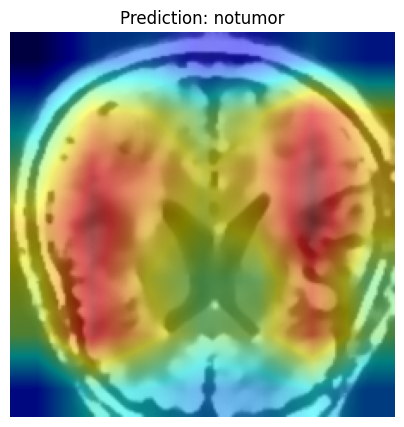

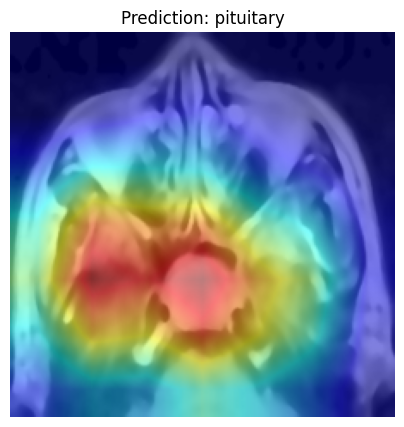

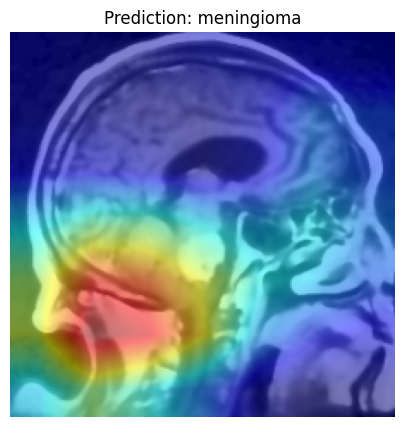

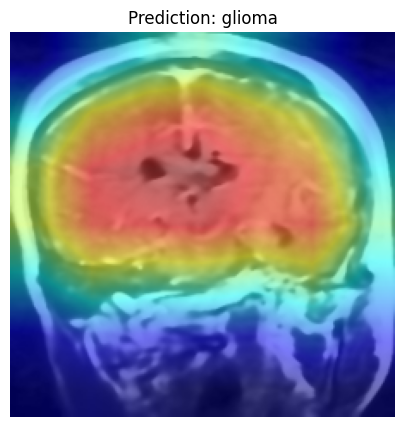

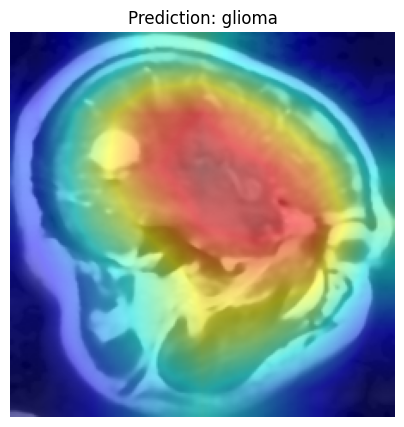

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Custom Dataset to load images
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to load data and split into train/test sets
def load_data(image_folder):
    image_paths = []
    labels = []

    class_names = os.listdir(image_folder)

    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                image_paths.append(img_path)
                labels.append(class_name)

    return image_paths, labels

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data
image_folder = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/Training'  # Update with the correct path
image_paths, labels = load_data(image_folder)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Create Datasets and DataLoaders
train_dataset = CustomDataset(X_train_paths, y_train, transform)
test_dataset = CustomDataset(X_test_paths, y_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet model and fine-tune
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))  # Adjust for your number of classes
model = model.to(device)

# Define loss function and optimizer
class_weights = torch.tensor([1.0, 5.0, 1.0, 3.0]).to(device)  # Adjust based on your class distribution
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Grad-CAM Visualization
target_layers = [model.layer4[-1]]  # Last layer of ResNet18
cam = GradCAM(model=model, target_layers=target_layers)

# Show Grad-CAM results on a few test images
for idx in range(min(5, len(X_test_paths))):
    img_path = X_test_paths[idx]
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    target = ClassifierOutputTarget(all_preds[idx])

    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])[0]

    # Resize image to match CAM size
    resized_image = transforms.Resize((grayscale_cam.shape[0], grayscale_cam.shape[1]))(image)
    rgb_img = np.array(resized_image).astype(np.float32) / 255.0  # Normalize to [0, 1]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    pred_label = label_encoder.classes_[all_preds[idx]]

    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Prediction: {pred_label}")
    plt.axis('off')
    plt.show()


In [ ]:
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Create output folder if not exists
output_folder = "gradcam_results"
os.makedirs(output_folder, exist_ok=True)

for idx in range(len(X_test_paths)):
    img_path = X_test_paths[idx]
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    target = ClassifierOutputTarget(all_preds[idx])

    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])[0]

    # Resize image to match CAM size
    resized_image = transforms.Resize((grayscale_cam.shape[0], grayscale_cam.shape[1]))(image)
    rgb_img = np.array(resized_image).astype(np.float32) / 255.0  # Normalize to [0, 1]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    pred_label = label_encoder.classes_[all_preds[idx]]
    true_label = label_encoder.classes_[y_test[idx]]  # Assuming y_test is available and aligned

    # Save the visualization
    save_path = os.path.join(output_folder, f"{idx}_pred_{pred_label}_true_{true_label}.png")
    plt.imsave(save_path, visualization)

    # Also optionally display
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Prediction: {pred_label}\nTrue: {true_label}")
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create output folder if not exists
output_folder = "gradcam_results"
os.makedirs(output_folder, exist_ok=True)

pdf_path = os.path.join(output_folder, "gradcam_visualizations.pdf")
with PdfPages(pdf_path) as pdf:
    for idx in range(len(X_test_paths)):
        img_path = X_test_paths[idx]
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        target = ClassifierOutputTarget(all_preds[idx])

        grayscale_cam = cam(input_tensor=input_tensor, targets=[target])[0]

        # Resize image to match CAM size
        resized_image = transforms.Resize((grayscale_cam.shape[0], grayscale_cam.shape[1]))(image)
        rgb_img = np.array(resized_image).astype(np.float32) / 255.0  # Normalize to [0, 1]

        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        pred_label = label_encoder.classes_[all_preds[idx]]
        true_label = label_encoder.classes_[y_test[idx]]  # Assuming y_test is available and aligned

        # Save individual image if needed
        save_path = os.path.join(output_folder, f"{idx}_pred_{pred_label}_true_{true_label}.png")
        plt.imsave(save_path, visualization)

        # Add to PDF
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(visualization)
        plt.title(f"Prediction: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved at: {pdf_path}")


PDF saved at: gradcam_results/gradcam_visualizations.pdf


In [ ]:
import pandas as pd

# Create a DataFrame to save results
results_df = pd.DataFrame({
    "Index": list(range(len(X_test_paths))),
    "Image_Path": X_test_paths,
    "Predicted_Label": [label_encoder.classes_[pred] for pred in all_preds],
    "True_Label": [label_encoder.classes_[true] for true in y_test]
})

# Save the DataFrame to CSV
csv_save_path = "gradcam_predictions.csv"
results_df.to_csv(csv_save_path, index=False)

print(f"Predictions saved to {csv_save_path}")

Predictions saved to gradcam_predictions.csv


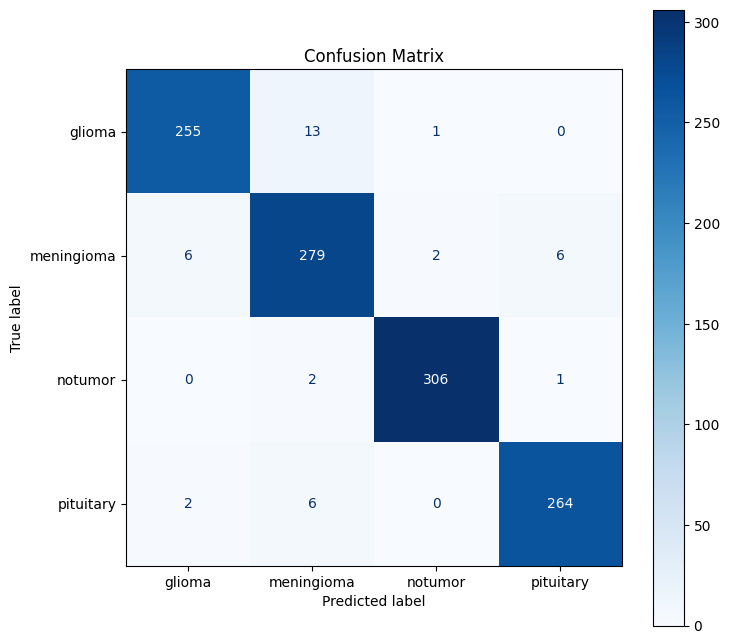

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.show()


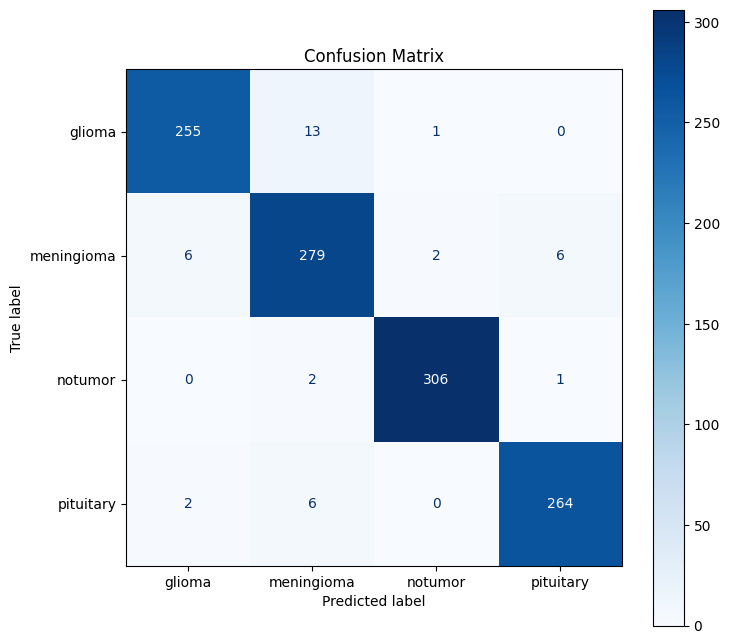

Accuracy: 96.59%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import joblib  # For saving label encoder
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data function
def load_data(image_folder):
    image_paths = []
    labels = []
    class_names = os.listdir(image_folder)

    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                image_paths.append(img_path)
                labels.append(class_name)

    return image_paths, labels

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
image_folder = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/Training'  # Your path
image_paths, labels = load_data(image_folder)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Train/test split
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Datasets and DataLoaders
train_dataset = CustomDataset(X_train_paths, y_train, transform)
test_dataset = CustomDataset(X_test_paths, y_test, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load and modify model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))
model = model.to(device)

# Loss and optimizer
class_weights = torch.tensor([1.0, 5.0, 1.0, 3.0]).to(device)  # Adjust as needed
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Save model and label encoder to Google Drive
save_path = "/content/drive/MyDrive/model_files"
os.makedirs(save_path, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_path, 'model.pth'))
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))
print(f"Saved model and label encoder to {save_path}")

# Grad-CAM Visualization
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Save Grad-CAM results in a folder
output_folder = os.path.join(save_path, "gradcam_results")
os.makedirs(output_folder, exist_ok=True)

from matplotlib.backends.backend_pdf import PdfPages
pdf_path = os.path.join(save_path, "GradCAM_Report.pdf")
pdf = PdfPages(pdf_path)

for idx in range(min(10, len(X_test_paths))):
    img_path = X_test_paths[idx]
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    target = ClassifierOutputTarget(all_preds[idx])

    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])[0]
    resized_image = transforms.Resize((grayscale_cam.shape[0], grayscale_cam.shape[1]))(image)
    rgb_img = np.array(resized_image).astype(np.float32) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    pred_label = label_encoder.classes_[all_preds[idx]]
    true_label = label_encoder.classes_[y_test[idx]]

    # Save as image
    save_path_img = os.path.join(output_folder, f"{idx}_pred_{pred_label}_true_{true_label}.png")
    plt.imsave(save_path_img, visualization)

    # Save to PDF
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Prediction: {pred_label}\nTrue: {true_label}")
    plt.axis('off')
    pdf.savefig()
    plt.close()

pdf.close()
print(f"Saved Grad-CAM PDF report to {pdf_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.3345
Epoch 2/20, Loss: 0.0631
Epoch 3/20, Loss: 0.0151
Epoch 4/20, Loss: 0.0057
Epoch 5/20, Loss: 0.0037
Epoch 6/20, Loss: 0.0060
Epoch 7/20, Loss: 0.0057
Epoch 8/20, Loss: 0.0498
Epoch 9/20, Loss: 0.0649
Epoch 10/20, Loss: 0.0200
Epoch 11/20, Loss: 0.0075
Epoch 12/20, Loss: 0.0019
Epoch 13/20, Loss: 0.0013
Epoch 14/20, Loss: 0.0007
Epoch 15/20, Loss: 0.0011
Epoch 16/20, Loss: 0.0012
Epoch 17/20, Loss: 0.0009
Epoch 18/20, Loss: 0.0005
Epoch 19/20, Loss: 0.0006
Epoch 20/20, Loss: 0.0017
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       269
  meningioma       0.97      0.95      0.96       293
     notumor       0.99      0.99      0.99       309
   pituitary       0.97      0.99      0.98       272

    accuracy                           0.98      1143
   macro avg       0.98      0.98      0.98      1143
weighted avg       0.98      0.98      0.98      1143

Confusion Matrix:
 [[261   7   

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import joblib
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from matplotlib.backends.backend_pdf import PdfPages

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load image paths and labels
def load_data(image_folder):
    image_paths = []
    labels = []
    class_names = os.listdir(image_folder)

    for class_name in class_names:
        class_folder = os.path.join(image_folder, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                image_paths.append(img_path)
                labels.append(class_name)

    return image_paths, labels

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load Saved Model and Label Encoder ===
model_path = '/content/drive/MyDrive/model_files/model.pth'
encoder_path = '/content/drive/MyDrive/model_files/label_encoder.pkl'

label_encoder = joblib.load(encoder_path)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model and label encoder loaded successfully.")

# === Load Test Images ===
test_folder = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/Testing'  # <-- Update if needed
image_paths, labels = load_data(test_folder)
encoded_labels = label_encoder.transform(labels)

test_dataset = CustomDataset(image_paths, encoded_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Make Predictions ===
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# === Report ===
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# === Grad-CAM Visualization ===
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Create output folder
output_path = '/content/drive/MyDrive/model_files/test_results'
os.makedirs(output_path, exist_ok=True)
pdf_path = os.path.join(output_path, 'Test_GradCAM_Report.pdf')
pdf = PdfPages(pdf_path)

# Visualize 10 examples
for idx in range(min(10, len(image_paths))):
    image = Image.open(image_paths[idx]).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    target = ClassifierOutputTarget(all_preds[idx])

    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])[0]
    resized_image = transforms.Resize((grayscale_cam.shape[0], grayscale_cam.shape[1]))(image)
    rgb_img = np.array(resized_image).astype(np.float32) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    pred_label = label_encoder.classes_[all_preds[idx]]
    true_label = label_encoder.classes_[all_labels[idx]]

    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Prediction: {pred_label}\nTrue: {true_label}")
    plt.axis('off')
    pdf.savefig()
    plt.close()

pdf.close()
print(f"Saved test Grad-CAM PDF report to: {pdf_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model and label encoder loaded successfully.
Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       300
  meningioma       0.94      0.97      0.96       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix:
[[281  15   2   2]
 [  3 297   4   2]
 [  0   1 404   0]
 [  1   2   0 297]]
Saved test Grad-CAM PDF report to: /content/drive/MyDrive/model_files/test_results/Test_GradCAM_Report.pdf



Predicted Tumor Type: NOTUMOR
Interpretation: MRI shows no evidence of a tumor, indicating a normal brain scan.


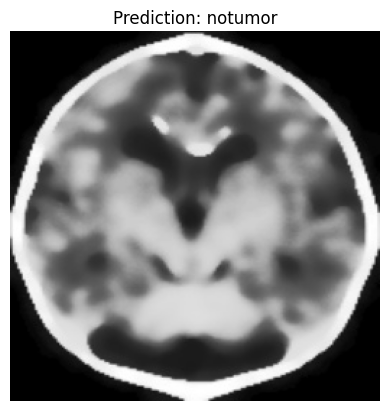

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import joblib
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and label encoder
model_path = '/content/drive/MyDrive/model_files/model.pth'
encoder_path = '/content/drive/MyDrive/model_files/label_encoder.pkl'

label_encoder = joblib.load(encoder_path)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Captions dictionary
captions = {
    "glioma": "MRI indicates the presence of a glioma, a type of tumor originating from glial cells.",
    "meningioma": "MRI suggests a meningioma, typically a slow-growing tumor arising from the meninges.",
    "pituitary": "MRI reveals a pituitary tumor, possibly affecting hormone secretion and nearby structures.",
    "notumor": "MRI shows no evidence of a tumor, indicating a normal brain scan."
}

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Function to predict from user image ===
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).cpu().item()
        class_name = label_encoder.classes_[pred]
        caption = captions[class_name]

    print(f"\nPredicted Tumor Type: {class_name.upper()}")
    print(f"Interpretation: {caption}")

    # Show image with prediction
    import matplotlib.pyplot as plt
    plt.imshow(image)
    plt.title(f"Prediction: {class_name}")
    plt.axis("off")
    plt.show()

# === User Input ===
# Example: Provide the full path to your image on Google Drive or local system
user_image_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/Training/notumor/Tr-no_0010.jpg'  # <-- Change this path as needed
predict_image(user_image_path)


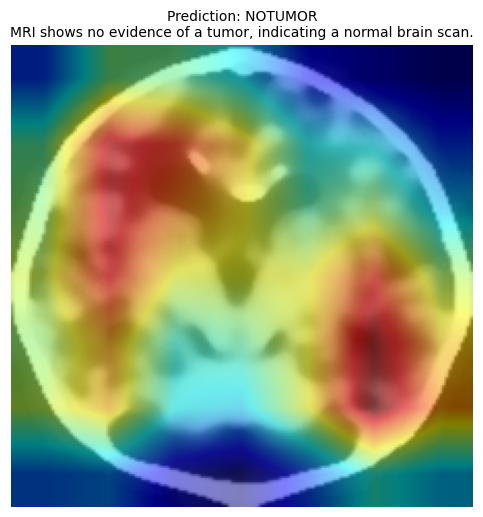

In [17]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import joblib
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load label encoder and model
encoder_path = '/content/drive/MyDrive/model_files/label_encoder.pkl'
model_path = '/content/drive/MyDrive/model_files/model.pth'

label_encoder = joblib.load(encoder_path)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Define captions
captions = {
    "glioma": "MRI indicates the presence of a glioma, a type of tumor originating from glial cells.",
    "meningioma": "MRI suggests a meningioma, typically a slow-growing tumor arising from the meninges.",
    "pituitary": "MRI reveals a pituitary tumor, possibly affecting hormone secretion and nearby structures.",
    "notumor": "MRI shows no evidence of a tumor, indicating a normal brain scan."
}

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Prediction + GradCAM function
def predict_and_explain(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    pred_label = label_encoder.classes_[pred]
    caption = captions[pred_label]

    # === Grad-CAM ===
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Prepare original image for overlay
    image_resized = image.resize((grayscale_cam.shape[1], grayscale_cam.shape[0]))
    rgb_img = np.array(image_resized).astype(np.float32) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Show Grad-CAM and caption
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"Prediction: {pred_label.upper()}\n{caption}", fontsize=10)
    plt.axis('off')
    plt.show()

# === USER INPUT: update this path ===
user_image_path = '/content/drive/MyDrive/cleaned/PreProcessing and Feature Extraction/Training/notumor/Tr-no_0010.jpg'  # <-- Replace with your image path
predict_and_explain(user_image_path)
